<a href="https://colab.research.google.com/github/naeldarw/birthdayreminder/blob/main/DLAV_Phase1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLAV Project - Phase 1

In this notebook we will train a very simple planner on data coming from a driving simulator. You are given a dash cam image of the current state of the driving vehicle, and the past positions of this vehicle, and you are asked to plan its future route.

This notebook will take you through steps on building this planner to solve the task. The full skeleton of the code together with some very simple implementations of each module are provided for your comfort. So all the cells below will run without you needing to change anything, but the performance won't be very good. You are asked to re-implement and play with most of the modules yourself to be able to have better performance.

P.S. to enable fast compute, you should use GPUs in google colab. The code works without GPUs, but it'll be much faster to use GPUs, specially if your model gets bigger and bigger! You can utilize Colab's GPUs by selecting "Change runtime type" in the Runtime menu on top of this page. There you can select "T4 GPU". This would restart your runtime, so you'll need to re-run everything from the top.

The first step is to prepare the data. The code below will download the data from google drive and extract it here for your code to use. Whenever your session gets restarted, remember to re-run this cell to re-download the data.

In [1]:
# Install gdown to handle Google Drive file download
!pip install -q gdown

import gdown
import zipfile

download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = "dlav_train.zip"
gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu"
output_zip = "dlav_val.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV"
output_zip = "dlav_test_public.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

Downloading...
From (original): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr
From (redirected): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr&confirm=t&uuid=6bcb7dcd-45bc-48a0-a566-626985e12536
To: /content/dlav_train.zip
100%|██████████| 439M/439M [00:04<00:00, 103MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu
From (redirected): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu&confirm=t&uuid=8f5d42fe-01ca-4520-ac82-db58837bce81
To: /content/dlav_val.zip
100%|██████████| 87.8M/87.8M [00:00<00:00, 255MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV
From (redirected): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV&confirm=t&uuid=ce372b46-7fb9-4884-9a4d-2727b9ef530b
To: /content/dlav_test_public.zip
100%|██████████| 86.6M/86.6M [00:00<00:00, 87.9MB/s]


Now lets load the data and visualize the first few examples to see what we are dealing with!

camera data shape is (200, 300, 3)
camera data shape is (200, 300, 3)
camera data shape is (200, 300, 3)
camera data shape is (200, 300, 3)


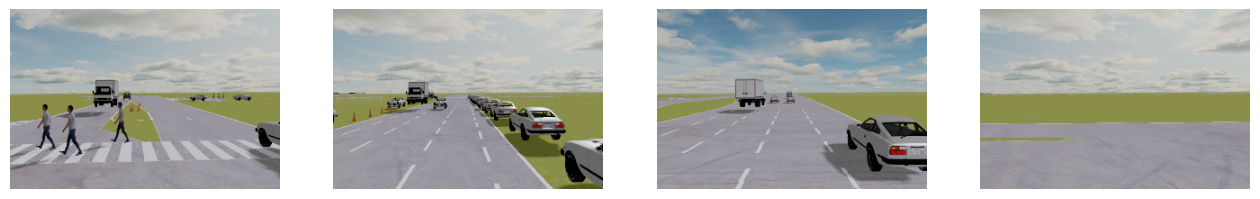

[[[167 174 174]
  [170 176 175]
  [173 179 177]
  ...
  [193 197 197]
  [191 195 197]
  [190 195 197]]

 [[168 174 174]
  [169 175 174]
  [170 176 175]
  ...
  [192 196 197]
  [191 196 197]
  [190 195 196]]

 [[167 173 172]
  [167 174 173]
  [168 175 174]
  ...
  [192 196 197]
  [191 196 197]
  [189 194 195]]

 ...

 [[148 144 151]
  [147 142 150]
  [148 143 151]
  ...
  [146 143 151]
  [146 142 151]
  [147 143 152]]

 [[146 141 149]
  [146 141 149]
  [146 141 149]
  ...
  [150 148 157]
  [152 149 158]
  [149 146 154]]

 [[152 148 156]
  [149 145 152]
  [147 143 150]
  ...
  [146 143 152]
  [143 140 149]
  [149 146 154]]]
[[[157 161 155]
  [157 161 156]
  [157 161 156]
  ...
  [211 208 200]
  [210 208 199]
  [209 206 198]]

 [[158 162 156]
  [158 162 157]
  [158 162 157]
  ...
  [210 208 200]
  [210 207 199]
  [210 207 200]]

 [[159 163 158]
  [158 162 157]
  [159 163 158]
  ...
  [208 206 198]
  [208 206 198]
  [209 207 199]]

 ...

 [[156 153 161]
  [155 152 160]
  [154 151 159]
  ..

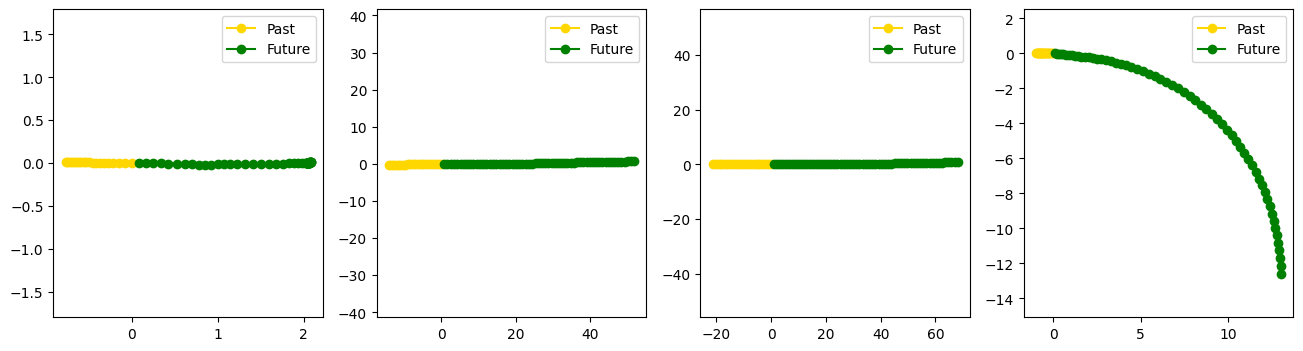

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random

k = 4
# load the data
data = []
for i in random.choices(np.arange(1000), k=k):
    with open(f"train/{i}.pkl", "rb") as f:
        data.append(pickle.load(f))

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    camera_data = data[i]["camera"]
    axis[i].imshow(camera_data)
    print(f"camera data shape is {camera_data.shape}")
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    #print(data[i]["sdc_history_feature"])
    print(data[i]["camera"])
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

Now its time to make our hands dirty!

In the following cells we will define the classes we need to do a proper training in pytorch.

1. We will start with defining a Dataset class which loads the data and does some basic preprocessing. You can further process this data as you see fit.
2. We then define the logger which receives training metrics and logs and prints/visualizes them. Having a good logger means a lot when dealing with neural network training! The logger implemented here is very simple and we strongly suggest you try other ways of visualizing your losses and metrics. Be creative ;)
3. We then proceed with defining the core part of the pipeline, the model. You are going to mainly implement the model yourself, but we have provided a very simple model so that the code runs as is so that you can see how the whole framework runs all in all.
4. Finally, we define the training funciton which contains the training loop, and we call it to see the magic! You'll need to also do a lot of changes here, from the batch size and learning rate, to adding augmentation schemes and schedulers, etc.

In [3]:
import os
import pickle
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torch.optim as optim

class DrivingDataset(Dataset):
    def __init__(self, file_list, transform=None, test=False):
        """
        file_list: list of .pkl paths
        transform : torchvision transforms to apply to the camera image
        test      : whether to include future label
        """
        self.samples  = file_list
        self.transform = transform
        self.test     = test

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # 1) load
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        # 2) camera: H×W×C numpy array (uint8 or float32)
        img_np = data['camera']
        # ensure uint8 for PIL
        if img_np.dtype != np.uint8:
            # if float in [0,1], scale up; else clip/round
            img_np = (255 * img_np).clip(0,255).astype(np.uint8)

        img = Image.fromarray(img_np)           # PIL Image
        if self.transform:
            camera = self.transform(img)         # tensor [C,H,W]
        else:
            # default: just to-tensor
            camera = T.ToTensor()(img)

        # 3) history / (future)
        history = torch.FloatTensor(data['sdc_history_feature'])
        if not self.test:
            future = torch.FloatTensor(data['sdc_future_feature'])
            return {'camera': camera, 'history': history, 'future': future}
        else:
            return {'camera': camera, 'history': history}

In [4]:
class Logger:
    def __init__(self):
        # Placeholder for potential future configs (e.g., log_dir, wandb_enabled, etc.)
        pass

    def log(self, step=None, **metrics):
        """
        Logs the given metrics.

        Args:
            step (int, optional): The current step or epoch. Useful for tracking.
            **metrics: Arbitrary keyword arguments representing metric names and values.
        """
        prefix = f"[Step {step}] " if step is not None else ""
        metric_str = " | ".join(f"{k}: {v}" for k, v in metrics.items())
        # print(prefix + metric_str)

In [8]:
import torch
import torch.nn as nn

class DrivingPlanner(nn.Module):
    def __init__(self,
                 img_h=200, img_w=300,
                 history_steps=21,
                 future_steps=60,
                 pool_size=(32, 32),
                 cnn_dropout=0.5,
                 trans_dropout=0.1,
                 trans_layers=1,
                 trans_heads=2):
        super().__init__()
        # Save for forward
        self.future_steps  = future_steps
        self.history_steps = history_steps

        # ── 1) CNN BACKBONE ─────────────────────────────────────────
        # Output features: (B, C=48, H/2, W/2)
        self.cnn_backbone = nn.Sequential(
            # Layer 1: downsample by 2
            nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # Layer 2
            nn.Conv2d(32, 48, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
            # Layer 3
            nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
            nn.Dropout2d(cnn_dropout)
        )

        # ── 2) TOKEN POOLING ─────────────────────────────────────────
        # Reduce spatial tokens from (H/2 * W/2) to (pool_h * pool_w)
        self.token_pool = nn.AdaptiveAvgPool2d(pool_size)
        pooled_h, pooled_w = pool_size
        num_tokens = pooled_h * pooled_w
        d_model    = 48  # must match CNN output channels

        # ── 3) POSITIONAL EMBEDDINGS ────────────────────────────────
        # One learnable embedding per spatial token
        self.pos_embed = nn.Parameter(torch.zeros(1, num_tokens, d_model))

        # ── 4) TRANSFORMER ENCODER ───────────────────────────────────
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=trans_heads,
            dim_feedforward=d_model * 2,
            dropout=trans_dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=trans_layers)

        # ── 5) FUSION & DECODER ──────────────────────────────────────
        flat_img_feats  = num_tokens * d_model
        flat_hist_feats = history_steps * 3
        decoder_in      = flat_img_feats + flat_hist_feats
        decoder_out     = future_steps * 3

        self.dropout = nn.Dropout(trans_dropout)
        self.decoder = nn.Linear(decoder_in, decoder_out)

    def forward(self, camera, history):
        # 1) CNN feature map: (B, 48, H/2, W/2)
        x = self.cnn_backbone(camera)

        # 2) Pool to reduce tokens: (B, 48, pool_h, pool_w)
        x = self.token_pool(x)

        # 3) Flatten spatial dims → (B, N, C)
        B, C, H, W = x.shape
        x = x.view(B, C, H * W).permute(0, 2, 1)

        # 4) Add positional embeddings
        x = x + self.pos_embed  # broadcast across batch

        # 5) Global self-attention
        x = self.transformer(x)  # (B, N, C)

        # 6) Flatten tokens → (B, N*C)
        img_feats = x.flatten(1)
        img_feats = self.dropout(img_feats)

        # 7) Flatten history and concatenate → (B, decoder_in)
        hist_flat = history.view(B, -1)
        fused     = torch.cat([img_feats, hist_flat], dim=1)

        # 8) Decode and reshape → (B, future_steps, 3)
        out = self.decoder(fused)
        out = out.view(B, self.future_steps, 3)
        return out


In [9]:
def train(model, train_loader, val_loader, optimizer, logger, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for idx, batch in enumerate(train_loader):
            camera = batch['camera'].to(device)
            history = batch['history'].to(device)
            future = batch['future'].to(device)

            optimizer.zero_grad()
            pred_future = model(camera, history)
            loss = criterion(pred_future[..., :2], future[..., :2])
            loss.backward()
            optimizer.step()

            if idx % 10 == 0:
                logger.log(step=epoch * len(train_loader) + idx, loss=loss.item())
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss, ade_all, fde_all = 0, [], []
        with torch.no_grad():
            for batch in val_loader:
                camera = batch['camera'].to(device)
                history = batch['history'].to(device)
                future = batch['future'].to(device)

                pred_future = model(camera, history)
                loss = criterion(pred_future, future)
                ADE = torch.norm(pred_future[:, :, :2] - future[:, :, :2], p=2, dim=-1).mean()
                FDE = torch.norm(pred_future[:, -1, :2] - future[:, -1, :2], p=2, dim=-1).mean()
                ade_all.append(ADE.item())
                fde_all.append(FDE.item())
                val_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | ADE: {np.mean(ade_all):.4f} | FDE: {np.mean(fde_all):.4f}')

In [10]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os

# Set up transforms
IMG_H, IMG_W = 200, 300

train_transform = T.Compose([
    T.RandomResizedCrop((IMG_H, IMG_W), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    # optionally normalize:
    # T.Normalize(mean=[0.485,0.456,0.406],
    #             std =[0.229,0.224,0.225]),
])

val_transform = T.Compose([
    T.Resize((IMG_H, IMG_W)),
    T.ToTensor(),
    # same Normalize if used above
])

# Build dataset
train_data_dir = "train"
val_data_dir = "val"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

train_dataset = DrivingDataset(train_files, transform=train_transform, test=False)
val_dataset   = DrivingDataset(val_files,   transform=val_transform,   test=False)

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2)

model = DrivingPlanner()

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)

logger = Logger()

train(model, train_loader, val_loader, optimizer, logger, num_epochs=50)


Epoch 1/50 | Train Loss: 57.9305 | Val Loss: 27.0534 | ADE: 6.6621 | FDE: 13.3661
Epoch 2/50 | Train Loss: 26.7372 | Val Loss: 18.4208 | ADE: 5.4362 | FDE: 11.0055
Epoch 3/50 | Train Loss: 20.6673 | Val Loss: 12.3928 | ADE: 4.1875 | FDE: 9.7790
Epoch 4/50 | Train Loss: 18.1348 | Val Loss: 14.2769 | ADE: 4.5402 | FDE: 9.1349
Epoch 5/50 | Train Loss: 17.2459 | Val Loss: 11.0729 | ADE: 3.8692 | FDE: 9.2088
Epoch 6/50 | Train Loss: 16.2649 | Val Loss: 11.8289 | ADE: 4.0556 | FDE: 10.1378
Epoch 7/50 | Train Loss: 15.6221 | Val Loss: 10.4867 | ADE: 3.7020 | FDE: 8.7665
Epoch 8/50 | Train Loss: 15.7594 | Val Loss: 10.6708 | ADE: 3.7503 | FDE: 8.9667
Epoch 9/50 | Train Loss: 14.9254 | Val Loss: 10.4024 | ADE: 3.5988 | FDE: 9.1267
Epoch 10/50 | Train Loss: 14.9710 | Val Loss: 9.9987 | ADE: 3.4854 | FDE: 8.8075
Epoch 11/50 | Train Loss: 14.5250 | Val Loss: 10.6551 | ADE: 3.6549 | FDE: 9.0425
Epoch 12/50 | Train Loss: 14.3401 | Val Loss: 11.9492 | ADE: 3.8705 | FDE: 10.0855
Epoch 13/50 | Train Lo

By running the code above, you have trained your first model!
What do you observe in terms of train and val losses? What is this phenomenon called? (Explain in a few lines below)




This model is very simple and does not necessarilly yield the optimal performance. You are asked to implement your own neural network architecture. You can use convolution networks, vision transformers, etc. Try with different architectures, different model sizes, and other hyper parameters such as learning rate and batch size to find the best performance. Other ideas could be to use augmentation thechniques to boost the performance, adding learning rate schedulers, and exploring other loss functions.

Once you are happy with your model, continue with the rest of the notebook to save your checkpoint and also visualize some plans coming from the model. The last cell will provide a `submission_phase1.csv` which you can submit to the leaderboard to see your results on the testing set.

In [ ]:
# save the model
torch.save(model.state_dict(), "phase1_model.pth")

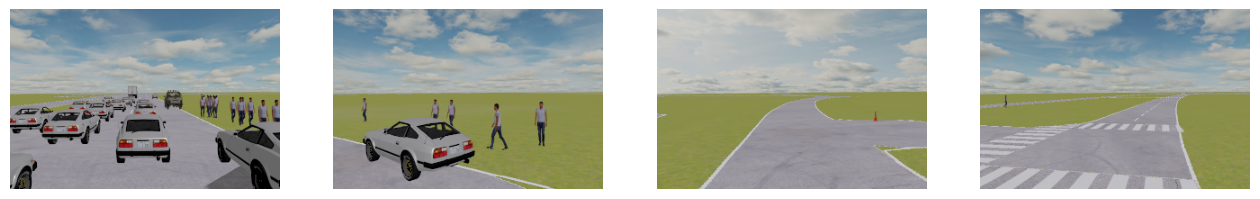

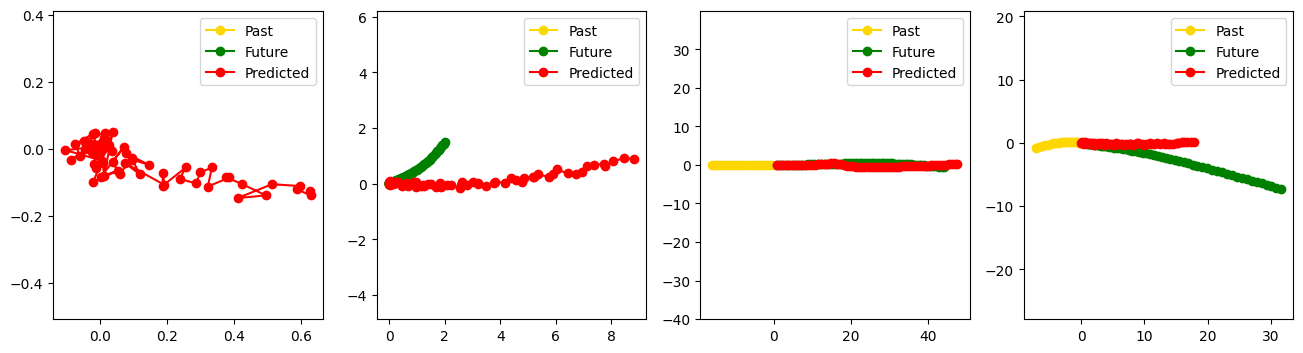

In [ ]:
val_batch_zero = next(iter(val_loader))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
camera = val_batch_zero['camera'].to(device)
history = val_batch_zero['history'].to(device)
future = val_batch_zero['future'].to(device)

model.eval()
with torch.no_grad():
    pred_future = model(camera, history)

camera = camera.cpu().numpy()
history = history.cpu().numpy()
future = future.cpu().numpy()
pred_future = pred_future.cpu().numpy()
k=4
selected_indices = random.choices(np.arange(len(camera)), k=k)
# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].imshow(camera[idx].transpose(1, 2, 0)/255)
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].plot(history[idx, :, 0], history[idx, :, 1], "o-", color="gold", label="Past")
    axis[i].plot(future[idx, :, 0], future[idx, :, 1], "o-", color="green", label="Future")
    axis[i].plot(pred_future[idx, :, 0], pred_future[idx, :, 1], "o-", color="red", label="Predicted")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

Now we run our model on the test set once, to get the plan of our model and save it for submission. Notice that the ground truth plans are removed for the test set, so you can not calculate the ADE metric on the test set yourself, and need to submit it to the leader board. By running the last cell, you'll be able to see a csv file called `submission_phase1.csv` by clicking on the folder icon on the left. Download it and submit it to the leaderboard to get your score.

In [ ]:
with open(f"test_public/0.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'semantic_label'])


In [ ]:
import pandas as pd
test_data_dir = "test_public"
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]

test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=2)
model.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)

        pred_future = model(camera, history)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase1.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (1000, 121)
